# # AWS CDK Deployment - Python Version - Part 4
This step defines the infrastructure for the data pipeline using AWS CDK (Python) to stand up and wire everything for automated ingestion and processing of the BLS + population datasets. 

**[View CloudShell/CDK Logs — Part 4 (Sanitized)](https://github.com/ScottySchmidt/AWS_DataEngineer_API/tree/main/docs/part4)**  
↑ That link shows the CloudShell based deploy for reference; this section documents the pure Python/CDK approach.

Uses AWS CDK (Python) to deploy the pipeline infrastructure:
- Lambda, S3, and SQS resources
- A daily ingest job (Parts 1 & 2)
- Automatic processing (Part 3) when new files land in S3

### Pipeline Flow
1. Deploy infrastructure with CDK (S3, Lambdas, SQS, EventBridge, IAM).
2. EventBridge triggers the Ingest Lambda daily.
3. Ingest writes fresh datasets to S3.
4. S3 emits object-created events to SQS (filtered for your files).
5. SQS invokes the Report Lambda to process/aggregate and write outputs.
6. CloudWatch Logs capture logs/metrics for both Lambdas.
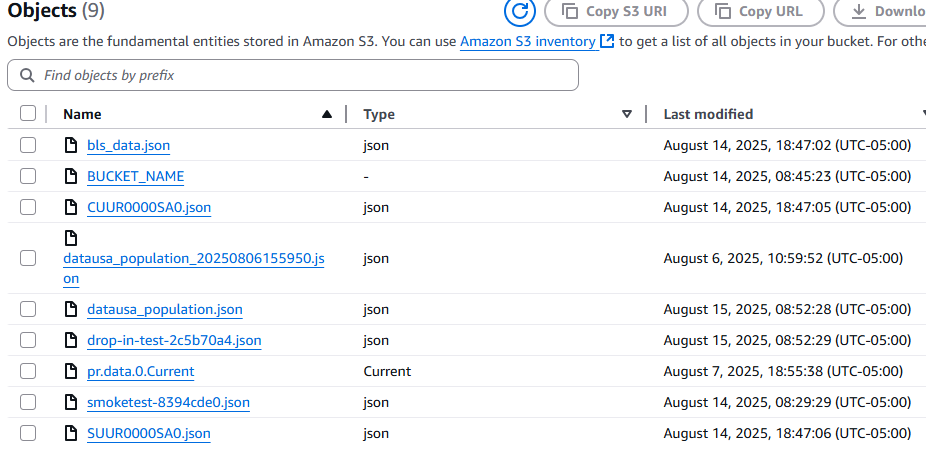
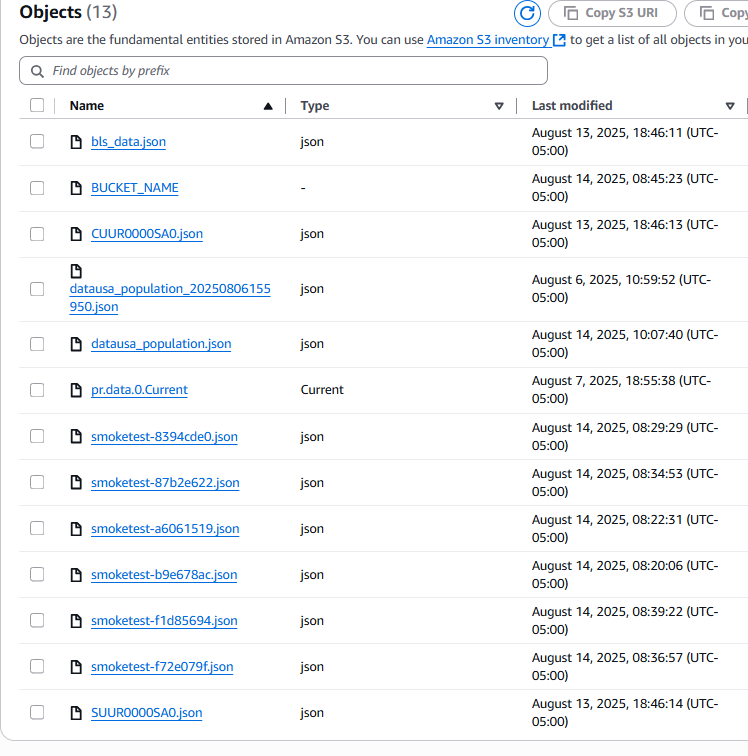

In [1]:
import os, json, boto3
import requests
import hashlib
from kaggle_secrets import UserSecretsClient
import time 
from botocore.exceptions import ClientError
start = time.time()
print("Running..")

# LOAD AWS SECRETS:
secrets = UserSecretsClient()
API_KEY = secrets.get_secret("BLS_API_KEY")
AWS_ACCESS_KEY_ID = secrets.get_secret("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = secrets.get_secret("AWS_SECRET_ACCESS_KEY")
AWS_REGION = secrets.get_secret("AWS_REGION")
REGION= AWS_REGION 
BUCKET_NAME = secrets.get_secret("BUCKET_NAME")
BUCKET=BUCKET_NAME

#AWS FILE NAMES:
LAMBDA_NAME = secrets.get_secret("LAMBDA_NAME")
QUEUE_NAME = secrets.get_secret("QUEUE_NAME")

# Setup AWS session and S3
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)
s3 = session.client("s3")

# Test S3 connection WITHOUT revealing keys
try:
    response = s3.list_objects_v2(Bucket=BUCKET_NAME)
    num_files = response.get('KeyCount', 0)
    print("S3 connection successful. Bucket contains: ", num_files)
except Exception as e:
    print("S3 connection failed: ", e)
print("Done.")

Running..
S3 connection successful. Bucket contains:  44
Done.


In [2]:
secrets = UserSecretsClient()

# Pull from Kaggle Secrets and mirror into environment vars
for key in ["AWS_ACCESS_KEY_ID", "AWS_SECRET_ACCESS_KEY", "AWS_REGION", "BUCKET_NAME"]:
    v = secrets.get_secret(key)
    if v:
        os.environ[key] = v

# If only AWS_REGION is set, mirror it to AWS_DEFAULT_REGION for libraries that expect that
if os.environ.get("AWS_REGION") and not os.environ.get("AWS_DEFAULT_REGION"):
    os.environ["AWS_DEFAULT_REGION"] = os.environ["AWS_REGION"]

print("Exported Kaggle secrets to env vars.")

Exported Kaggle secrets to env vars.


In [3]:
# CREATE SQS QUEUE AND FETCH ARN: 
REGION = "us-east-1"
QUEUE_NAME = "BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU"  # or discover by prefix

sqs = boto3.client("sqs", region_name=REGION)

# 1) Get the existing queue URL
qurl = sqs.get_queue_url(QueueName=QUEUE_NAME)["QueueUrl"]

# 2) (Optional) Update attributes to what you want
sqs.set_queue_attributes(
    QueueUrl=qurl,
    Attributes={
        "VisibilityTimeout": "300"  # 5 minutes
    }
)

# 3) Fetch ARN if you need to wire S3/EventBridge → SQS
attrs = sqs.get_queue_attributes(QueueUrl=qurl, AttributeNames=["QueueArn"])["Attributes"]
queue_arn = attrs["QueueArn"]
print("Queue URL:", bool(qurl))
print("Queue ARN:", bool(queue_arn))


Queue URL: True
Queue ARN: True


In [4]:
import uuid
import sys
# s3_sqs_lambda_smoketest.py
def queue_url(name: str) -> str:
    return sqs.get_queue_url(QueueName=name)["QueueUrl"]

def depth(qurl: str) -> int:
    a = sqs.get_queue_attributes(
        QueueUrl=qurl,
        AttributeNames=["ApproximateNumberOfMessages"]
    )["Attributes"]["ApproximateNumberOfMessages"]
    return int(a)

def main():
    qurl = queue_url(QUEUE_NAME)

    # 1) Drop a tiny test object in S3 (unique key)
    key = f"smoketest-{uuid.uuid4().hex[:8]}.json"
    s3.put_object(Bucket=BUCKET_NAME, Key=key, Body=json.dumps({"ping": True}).encode())

    try:
        # 2) Prove S3→SQS: wait for queue depth to bump
        s3_to_sqs_ok = False
        for _ in range(30):  # ~30s
            if depth(qurl) >= 1:
                s3_to_sqs_ok = True
                break
            time.sleep(1)

        # 3) Prove SQS→Lambda: wait for queue to drain back to 0
        sqs_to_lambda_ok = False
        for _ in range(180):  # up to ~3 min for cold starts/backoff
            if depth(qurl) == 0:
                sqs_to_lambda_ok = True
                break
            time.sleep(1)

        wired = s3_to_sqs_ok and sqs_to_lambda_ok
        print("WIRED: TRUE" if wired else "WIRED: FALSE")
        #sys.exit(0 if wired else 1)

    finally:
        # 4) Cleanup the test object (best effort)
        try:
            s3.delete_object(Bucket=BUCKET_NAME, Key=key)
        except Exception:
            pass

if __name__ == "__main__":
    main()

WIRED: FALSE


In [5]:
#LAMBDA SMOKE TEST: 
lam = session.client("lambda")
fns = lam.list_functions()['Functions']
names = []
for function in fns:
    name = function["FunctionName"]
    names.append(name)
print("Functions:", names)

Functions: ['bls-github-ci-sandbox', 'BlsPipelineStack-BlsReportFn1ABE5E21-0qZIzspWVVtL', 'CFN-SM-IM-Lambda-catalog-DelayLambda-GH20qvggV0UO', 'BlsPipelineStack-BlsIngestFnCD0BBA37-KqHbWeaT1WT3', 'bls-ingest', 'CFGetCatalogRoles', 'RearcBLSLambda', 'CFGetDefaultVpcIdTut', 'S3FileProcessorLambda', 'GitHubWebhookLambda', 'BlsPipelineStack-BucketNotificationsHandler050a058-iFZUwiLm9Toh', 'CFEnableSagemakerProjectsTut']


In [6]:
sqs = boto3.client("sqs", region_name=REGION)

try:
    QUEUE_URL = sqs.get_queue_url(QueueName=QUEUE_NAME)["QueueUrl"]
    QUEUE_ARN = sqs.get_queue_attributes(
        QueueUrl=QUEUE_URL,
        AttributeNames=["QueueArn"]
    )["Attributes"]["QueueArn"]
    print("SQS ready")
except ClientError as e:
    print("Failed to resolve existing queue:", e)

SQS ready


In [7]:
from botocore.config import Config
# CONFIG:
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
INGEST_LAMBDA = os.getenv("INGEST_LAMBDA", LAMBDA_NAME)  # your new ingest function

# boto3 client with sensible timeouts/retries
lam = boto3.client(
    "lambda",
    region_name=AWS_REGION,
    config=Config(connect_timeout=3, read_timeout=10, retries={"max_attempts": 2})
)

# INVOKE:
resp = lam.invoke(
    FunctionName=INGEST_LAMBDA,
    InvocationType="RequestResponse",
    Payload=json.dumps({}).encode("utf-8")  # send an empty JSON payload
)

status = resp.get("StatusCode")
print("Status:", status)

Status: 200


In [8]:
import json, base64
resp = lam.invoke(
    FunctionName=INGEST_LAMBDA,  # your Lambda name
    InvocationType="RequestResponse"
)
status = resp.get("StatusCode")
err = resp.get("FunctionError")

# Read the payload ONCE
raw_payload = resp["Payload"].read()

# Decode Lambda logs if they exist
if "LogResult" in resp:
    print("Lambda Logs")
    print(base64.b64decode(resp["LogResult"]).decode("utf-8", "ignore"))

# Decode 
if raw_payload:
    try:
        payload_json = json.loads(raw_payload.decode("utf-8"))
        print("Payload")
        print(json.dumps(payload_json, indent=2))
    except Exception:
        print("Payload (raw)")
        print(raw_payload.decode("utf-8", "ignore"))
else:
    print("Payload is empty")

if status == 200:
    print("Result. Status = 200")
else:
    print("Error: ", err)

Payload
{
  "statusCode": 200,
  "body": "upload complete"
}
Result. Status = 200


In [9]:
# Verify Right Region:
s3 = boto3.client("s3", region_name=os.getenv("AWS_REGION") or "us-east-1")
loc = s3.get_bucket_location(Bucket=BUCKET_NAME).get("LocationConstraint") or "us-east-1"
print("BucketRegion==ClientRegion?", loc == s3.meta.region_name)

BucketRegion==ClientRegion? True


In [10]:
from botocore.exceptions import ClientError
# File Names:
print([o["Key"] for o in s3.list_objects_v2(Bucket=BUCKET_NAME).get("Contents", [])[:10]])

['CUUR0000SA0.json', 'SUUR0000SA0.json', 'bls_data.json', 'datausa_population.json', 'drop-in-test-11820cd3.json', 'drop-in-test-20a184b4.json', 'drop-in-test-8c5cd535.json', 'drop-in-test-ac9f2f1a.json', 'drop-in-test-e3b2760f.json', 'pr.data.0.Current']


In [11]:
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)

# This summary is all info we need and has no secret info:
summary = {
    "status": resp["ResponseMetadata"]["HTTPStatusCode"],
    "key_count": resp.get("KeyCount", 0),
    "truncated": bool(resp.get("IsTruncated")),
}
print(summary)

{'status': 200, 'key_count': 44, 'truncated': False}


In [12]:
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)
for o in resp.get("Contents", []):
    print(o["Key"])  # or process
print("Done")

CUUR0000SA0.json
SUUR0000SA0.json
bls_data.json
datausa_population.json
drop-in-test-11820cd3.json
drop-in-test-20a184b4.json
drop-in-test-8c5cd535.json
drop-in-test-ac9f2f1a.json
drop-in-test-e3b2760f.json
pr.data.0.Current
replay/bls_data-0777ae.json
replay/bls_data-108b32.json
replay/bls_data-1c187e.json
replay/bls_data-253cd0.json
replay/bls_data-2c3020.json
replay/bls_data-3b8622.json
replay/bls_data-3c0681.json
replay/bls_data-424c9b.json
replay/bls_data-491a63.json
replay/bls_data-4e3762.json
replay/bls_data-6972d4.json
replay/bls_data-71acec.json
replay/bls_data-725ba9.json
replay/bls_data-7711b6.json
replay/bls_data-8028d2.json
replay/bls_data-8e4eac.json
replay/bls_data-934fbb.json
replay/bls_data-937a79.json
replay/bls_data-96dfb9.json
replay/bls_data-a0c529.json
replay/bls_data-a35acb.json
replay/bls_data-a6f085.json
replay/bls_data-a7f6ae.json
replay/bls_data-ab1152.json
replay/bls_data-b3802f.json
replay/bls_data-b98bb8.json
replay/bls_data-b9ee3c.json
replay/bls_data-ba6

In [13]:
# Test: Consumer Lambda is hooked to the queue and enabled?
REGION=REGION
QUEUE_ARN="arn:aws:sqs:us-east-1:933832705314:BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU".strip()

lam=boto3.client("lambda", region_name=REGION)
resp=lam.list_event_source_mappings(EventSourceArn=QUEUE_ARN)
for m in resp.get("EventSourceMappings", []):
    lname = m["FunctionArn"].split(":function:")[-1]
    print("Consumer Lambda:", lname, "| State:", m["State"], "| UUID:", m["UUID"])


Consumer Lambda: BlsPipelineStack-BlsReportFn1ABE5E21-0qZIzspWVVtL | State: Enabled | UUID: 49a08c6e-b8ae-477b-85b0-d60978956cc7
Consumer Lambda: RearcBLSLambda | State: Enabled | UUID: 8c1f86a7-c7fd-4f8e-8eea-4f78e97a1faf


In [14]:
import uuid
# Checks if S3 event happened and queue emptied..
PREFIX = ""  # for root
test_key = f"{PREFIX}smoketest-{uuid.uuid4().hex[:8]}.json"

# 1) Upload test file to trigger pipeline (should trigger S3->SQS->Lambda)
s3.put_object(Bucket=BUCKET_NAME, Key=test_key, Body=b'{"ping":true}')

# Queue depth 0 → Report Lambda processed message
qurl = QUEUE_URL  # assigns the QUEUE_URL
def depth():
    a = sqs.get_queue_attributes(
        QueueUrl=qurl,
        AttributeNames=["ApproximateNumberOfMessages"]
    )["Attributes"]["ApproximateNumberOfMessages"]
    return int(a)

# Check Queue Until Empty:
for _ in range(12):  
    time.sleep(1)
    if depth() == 0:
        break

# cleanup the test object
s3.delete_object(Bucket=BUCKET_NAME, Key=test_key)
print("E2E smoke: PASS")

E2E smoke: PASS


In [15]:
# Make a unique, throwaway test filename so we don't collide with anything
test_key = "drop-in-test-{}.json".format(uuid.uuid4().hex[:8])
test_body = json.dumps({"ping": True})

# 1) Drop a tiny test object into S3
s3.put_object(
    Bucket= BUCKET_NAME,
    Key=test_key,
    Body=test_body
)
print("Dropped a test object to S3 as: " + test_key)

# 2) Chill for a few seconds so events can propagate
time.sleep(5)

# 3) Peek at SQS to see if the queue bumped (aka we triggered something)
resp = sqs.get_queue_attributes(
    QueueUrl=QUEUE_URL,
    AttributeNames=["ApproximateNumberOfMessages"]
)
depth = int(resp["Attributes"]["ApproximateNumberOfMessages"])
print("Queue depth after the drop: " + str(depth))

Dropped a test object to S3 as: drop-in-test-2d325c72.json
Queue depth after the drop: 0


In [16]:
#RUN LAMBDA FUNCTION
lam = boto3.client("lambda", region_name="us-east-1")
resp = lam.invoke(
    FunctionName=LAMBDA_NAME,
    InvocationType="RequestResponse",
    LogType="Tail",
    Payload=json.dumps({"force": True}).encode("utf-8"),
)

print("HTTP:", resp["StatusCode"])
print("Lambda error?", resp.get("FunctionError"))
print("Return:", resp["Payload"].read().decode("utf-8"))

if "LogResult" in resp:
    print("LOG:")
    print(base64.b64decode(resp["LogResult"]).decode("utf-8"))

HTTP: 200
Lambda error? None
Return: {"statusCode": 200, "body": "upload complete"}
LOG:
START RequestId: b1942e9c-50c2-4c8b-8a10-ad4703fb958d Version: $LATEST
END RequestId: b1942e9c-50c2-4c8b-8a10-ad4703fb958d
REPORT RequestId: b1942e9c-50c2-4c8b-8a10-ad4703fb958d	Duration: 306.38 ms	Billed Duration: 307 ms	Memory Size: 128 MB	Max Memory Used: 92 MB	



In [17]:
# Add SQS → Lambda trigger
MAPPING_UUID="49a08c6e-b8ae-477b-85b0-d60978956cc7"

lam = boto3.client("lambda", region_name=REGION)

# See the exact source ARN + state
detail = lam.get_event_source_mapping(UUID=MAPPING_UUID)
print("State:", detail["State"])
print("EventSourceArn:", detail["EventSourceArn"])
print("FunctionArn:", detail["FunctionArn"])

# If it isn't Enabled, turn it on (safe to run; no-op if already enabled)
lam.update_event_source_mapping(
    UUID=MAPPING_UUID,
    Enabled=True,
    BatchSize=10,
    MaximumBatchingWindowInSeconds=5,
)

State: Enabled
EventSourceArn: arn:aws:sqs:us-east-1:933832705314:BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU
FunctionArn: arn:aws:lambda:us-east-1:933832705314:function:BlsPipelineStack-BlsReportFn1ABE5E21-0qZIzspWVVtL


{'ResponseMetadata': {'RequestId': 'd6c6c345-f886-4dfb-af8f-eefcc363b2b2',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Tue, 19 Aug 2025 02:26:28 GMT',
   'content-type': 'application/json',
   'content-length': '1171',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd6c6c345-f886-4dfb-af8f-eefcc363b2b2'},
  'RetryAttempts': 0},
 'UUID': '49a08c6e-b8ae-477b-85b0-d60978956cc7',
 'BatchSize': 10,
 'MaximumBatchingWindowInSeconds': 5,
 'EventSourceArn': 'arn:aws:sqs:us-east-1:933832705314:BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU',
 'FunctionArn': 'arn:aws:lambda:us-east-1:933832705314:function:BlsPipelineStack-BlsReportFn1ABE5E21-0qZIzspWVVtL',
 'LastModified': datetime.datetime(2025, 8, 19, 2, 26, 28, 31000, tzinfo=tzlocal()),
 'State': 'Updating',
 'StateTransitionReason': 'USER_INITIATED',
 'FunctionResponseTypes': [],
 'EventSourceMappingArn': 'arn:aws:lambda:us-east-1:933832705314:event-source-mapping:49a08c6e-b8ae-477b-85b0-d60978956cc7'}

In [18]:
# Verifies S3→SQS and SQS→Lambda wiring target the same queue.
QUEUE_URL="https://sqs.us-east-1.amazonaws.com/933832705314/BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU"

sqs=boto3.client("sqs", region_name=REGION)
s3 =boto3.client("s3",  region_name=REGION)
sts=boto3.client("sts", region_name=REGION)


acct = sts.get_caller_identity()["Account"]
qattrs = sqs.get_queue_attributes(QueueUrl=QUEUE_URL, AttributeNames=["All"])["Attributes"]

# Print Basics no confidential info:
print("KmsKey attached:", bool(qattrs.get("KmsMasterKeyId")))
print("Queue exists:", "QueueArn" in qattrs)
print("Bucket exists:", bool(BUCKET))
print("Account check: OK")

print("\nS3 notifications configured:",
      bool(s3.get_bucket_notification_configuration(Bucket=BUCKET)))


KmsKey attached: False
Queue exists: True
Bucket exists: True
Account check: OK

S3 notifications configured: True


In [19]:
# PRINT QUEUES
QUEUE_URL="https://sqs.us-east-1.amazonaws.com/933832705314/BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU"  

s3=boto3.client("s3", region_name=REGION)
sqs=boto3.client("sqs", region_name=REGION)

new_key=f"replay/bls_data-{uuid.uuid4().hex[:6]}.json"
s3.copy_object(Bucket=BUCKET, CopySource={"Bucket":BUCKET,"Key":"bls_data.json"}, Key=new_key)
print("dropped:", new_key)

for _ in range(6):
    depth=int(sqs.get_queue_attributes(QueueUrl=QUEUE_URL, AttributeNames=["ApproximateNumberOfMessages"])["Attributes"]["ApproximateNumberOfMessages"])
    print("queue depth:", depth); time.sleep(1)

dropped: replay/bls_data-d426e1.json
queue depth: 0
queue depth: 0
queue depth: 0
queue depth: 0
queue depth: 0
queue depth: 0


In [20]:
#QUEUE_URL = "https://sqs.us-east-1.amazonaws.com/933832705314/BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOgqIIfU"

resp = sqs.get_queue_attributes(
    QueueUrl=QUEUE_URL,
    AttributeNames=["ApproximateNumberOfMessages","QueueArn"]
)
print(resp["Attributes"])

{'ApproximateNumberOfMessages': '0', 'QueueArn': 'arn:aws:sqs:us-east-1:933832705314:BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU'}


In [21]:
# Wiring check: S3 → SQS → Lambda
def check(flag, message):
    if flag:
        print("✅ " + message)
    else:
        print("❌ " + message)
    return flag

# Step 1: make sure the queue actually exists
try:
    qurl = sqs.get_queue_url(QueueName=QUEUE_NAME)["QueueUrl"]
    qattrs = sqs.get_queue_attributes(
        QueueUrl=qurl, 
        AttributeNames=["QueueArn"]
    )["Attributes"]
    qarn = qattrs["QueueArn"]
    check(True, "Queue found")
except Exception as err:
    raise SystemExit("Could not find the queue. Double-check QUEUE_NAME. Error: " + str(err))


# 2) Check if S3 sends notifications to this queue
notif = s3.get_bucket_notification_configuration(Bucket=BUCKET_NAME) or {}
qcfgs = notif.get("QueueConfigurations", []) or []
targets = []
for c in qcfgs:
    events = c.get("Events") or []
    if c.get("QueueArn") == qarn and "s3:ObjectCreated:*" in events:
        targets.append(c)

has_s3_to_sqs = check(len(targets) > 0, "S3 → SQS notification ok? (" + str(len(targets)) + " found)")

# 3) Check if Lambda is mapped to the queue
mappings = lam.list_event_source_mappings(FunctionName=LAMBDA_NAME).get("EventSourceMappings", [])
m_to_queue = []
for m in mappings:
    if m.get("EventSourceArn") == qarn and m.get("State") == "Enabled":
        m_to_queue.append(m)

has_sqs_to_lambda = check(len(m_to_queue) > 0, "SQS → Lambda mapping ok? (" + str(len(m_to_queue)) + " found)")

# 4) Final summary
print("--- Summary ---")
if has_s3_to_sqs and has_sqs_to_lambda:
    print("✅ End-to-end wiring looks good. S3 → SQS → Lambda is connected.")
else:
    print("❌ Wiring not complete. Either S3 is not hooked to SQS, or Lambda is not hooked to the queue.")

✅ Queue found
✅ S3 → SQS notification ok? (1 found)
✅ SQS → Lambda mapping ok? (1 found)
--- Summary ---
✅ End-to-end wiring looks good. S3 → SQS → Lambda is connected.


In [22]:
# Look up the bucket’s notification configuration
config = s3.get_bucket_notification_configuration(Bucket=BUCKET_NAME) or {}

# Filter down to any rules that send ObjectCreated events to our queue
targets = [
    rule for rule in config.get("QueueConfigurations", [])
    if rule.get("QueueArn") == queue_arn
       and "s3:ObjectCreated:*" in (rule.get("Events") or [])
]

# Print a simple status check
print("Number of S3→SQS ObjectCreated targets:", len(targets))
print("✅ Found one!" if targets else "❌ None found")

Number of S3→SQS ObjectCreated targets: 1
✅ Found one!


In [23]:
# VERIFY the SQS → Lambda hookup
queue_arn = queue_arn 

# Find mappings from THIS queue to THIS function
mappings = lam.list_event_source_mappings(FunctionName=LAMBDA_NAME).get("EventSourceMappings", [])
mappings = [m for m in mappings if m.get("EventSourceArn") == queue_arn]

if not mappings:
    print("❌ No SQS→Lambda event source mapping found.")
else:
    m = mappings[0]
    print("✅ Mapping found")
    print("  UUID: ", m.get("UUID"))
    print("  State:", m.get("State"))                 # should be "Enabled"
    print("  BatchSize:", m.get("BatchSize"))
    print("  MaxBatchingWindowInSeconds:", m.get("MaximumBatchingWindowInSeconds"))

✅ Mapping found
  UUID:  8c1f86a7-c7fd-4f8e-8eea-4f78e97a1faf
  State: Enabled
  BatchSize: 5
  MaxBatchingWindowInSeconds: 0


In [24]:
end = time.time()
print(round(end - start, 2), " seconds")

50.15  seconds


#### Conclusion
That wraps up Part 4 Python version – Infrastructure as Code & the automated pipeline.

**[View GitHub Repository with All Parts](https://github.com/ScottySchmidt/AWS_DataEngineer_API)**